In [1]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


Импорт необходимых модулей

In [2]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib as mpl

Расчет многофазного потока в пласте. Индикаторная кривая

In [3]:
## Физико-химические свойства флюида PVT
gamma_gas_ = 0.8 # удельная плотность газа, по воздуху;
gamma_oil_ = 0.88 # удельная плотность нефти, по воде;
gamma_wat_ = 1 # удельная плотность воды, по воде;
Rsb_ = 80 # газосодержание при давлении насыщения, м3/м3;
Rp_  = 80 # замерной газовый фактор, м3/м3;
Pb_cal_ = 120 # давление насыщения при температуре пласта, атм;
Tres_ = 100 # пластовая температура, С;
Bob_ = 1.2 # объемный коэффициент нефти, м3/м3;
muob_ = 1 # вязкость нефти при давлении насыщения, сП;
fw_ = 50 # объемная обводненность, %;
# На случай, если не будем задавать значение давления насыщения, рассчитаем его:
Pb_ = UniflocVBA.PVT_pb_atma(Tres_, gamma_gas_, gamma_oil_, gamma_wat_, Rsb_, Rp_, Pb_cal_, Tres_, Bob_, muob_)
## Измеренные значения дебита и забойного давления
qltset_ = 55 # тестовый дебит скважины, ст.м3/сут;
Pwftest_ = 45 # тестовое забойное давление, абс. атм;
## Парамтры пласта
Pres_ = 150 # пластовое давление, абс. атм;
# Рассчитаем коэффициент продуктивности пласта по данным тестовой эксплуатации:
PI_ = UniflocVBA.IPR_pi_sm3dayatm(qltset_, Pwftest_, Pres_, fw_, Pb_)
# Рассчитаем максимальный дебит скважины по давлению и продуктивности:
qmax_ = UniflocVBA.IPR_qliq_sm3day(PI_, Pres_, 1, fw_, Pb_)
## Настройка графика
N_ = 20
## PVT строка
PVT_str = UniflocVBA.PVT_encode_string(gamma_gas_, gamma_oil_, gamma_wat_, Rsb_, Rp_, Pb_, Tres_, Bob_, muob_)

Расчет парамтеров для индикаторной кривой двумя способами - забойное давление по дебиту и наоборот.

In [4]:
dQ = qmax_/N_ 
Q_ = np.arange(0, qmax_+1, dQ) #
pwf_list, qliq_list = [], []
for q in Q_:
    pwf_atm = UniflocVBA.IPR_pwf_atma(PI_, Pres_, q, fw_, Pb_)
    pwf_list.append(pwf_atm)
    qliq_sm3day = UniflocVBA.IPR_qliq_sm3day(PI_, Pres_, pwf_atm, fw_, Pb_)
    qliq_list.append(qliq_sm3day)

Индикаторная кривая

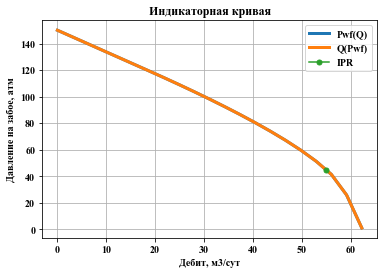

In [5]:
mpl.rcParams['font.family'] = 'fantasy'
mpl.rcParams['font.fantasy'] = 'Times New Roman'

x = [ Q_, qliq_list]
ys = [ pwf_list, pwf_list]
for i in range(2):
    plt.grid(True)
    plt.title('Индикаторная кривая', color='black', family='fantasy')
    plt.ylabel('Давление на забое, атм', color='black', family='fantasy')
    plt.xlabel('Дебит, м3/сут', color='black', family='fantasy')
    plt.plot(x[i], ys[i], linewidth=3)
plt.plot(qltset_, Pwftest_, marker = 'o', markersize=5)
plt.legend(('Pwf(Q)','Q(Pwf)','IPR')) 
plt.show()

Рассчитаем расход ГЖС от забойноо давления и долю газа в потоке от забойного давления

In [6]:
q_mix_rc_list, gas_frac_list = [], []
i=-1
for p in pwf_list:
    i+=1
    q_mix_rc_m3day = UniflocVBA.MF_q_mix_rc_m3day(qliq_list[i], fw_, p, Tres_, PVT_str)
    q_mix_rc_list.append(q_mix_rc_m3day)
    gas_fraction_d = UniflocVBA.MF_gas_fraction_d(p, Tres_, fw_, PVT_str)
    gas_frac_list.append(gas_fraction_d)

Зависимости расхода ГЖС от забойного давления и доли газа в потоке от забойного давления

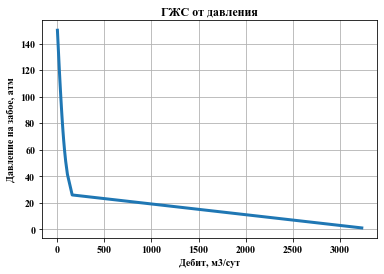

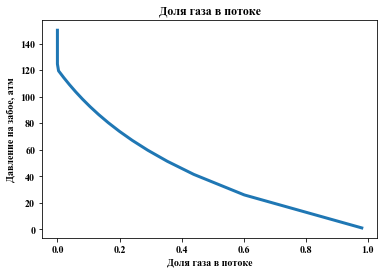

In [7]:
plt.grid(True)
plt.title('ГЖС от давления', color='black', family='fantasy')
plt.ylabel('Давление на забое, атм', color='black', family='fantasy')
plt.xlabel('Дебит, м3/сут', color='black', family='fantasy')
plt.plot(q_mix_rc_list, pwf_list, linewidth=3)
plt.show()

plt.title('Доля газа в потоке', color='black', family='fantasy')
plt.ylabel('Давление на забое, атм', color='black', family='fantasy')
plt.xlabel('Доля газа в потоке', color='black', family='fantasy')
plt.plot(gas_frac_list, pwf_list, linewidth=3)
plt.show()